In [32]:
import torch
import os
import os.path as osp
import matplotlib.pyplot as plt
import numpy as np

import utils
from utils import load_plot_2d


In [28]:
ROOT_DIR = (os.path.abspath(''))
MODEL_DIR = os.path.join(ROOT_DIR, "pt_models")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Reproduced results on synthetic dataset

## MCC and model loss

In [3]:
def plot_test_performances():
    """
    Plots the MCC and Deep Energy results of the base dataset for seeds 1 to 60.
    """
    with open(osp.join('results', 'eval_performances.txt')) as f:
        performances = list(map(eval, f.readline().split(',')[1:]))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
    fig.tight_layout()

    ax1.plot(performances, '-.', color='gold', label=f'iFlow:{round(np.mean(performances), 4)}({round(np.std(performances), 4)})')
    ax1.legend()
    ax1.set_xlabel('Seed Number')
    ax1.set_ylabel('MCC')

    energy_values = np.load(os.path.join('results', 'energy_values.npy'))

    ax2.plot(energy_values, '-.', color='gold', label=f'iFlow:{round(np.mean(energy_values), 4)}')
    ax2.legend()
    ax2.set_xlabel('Seed Number')
    ax2.set_ylabel('Energy Value')
    plt.show()

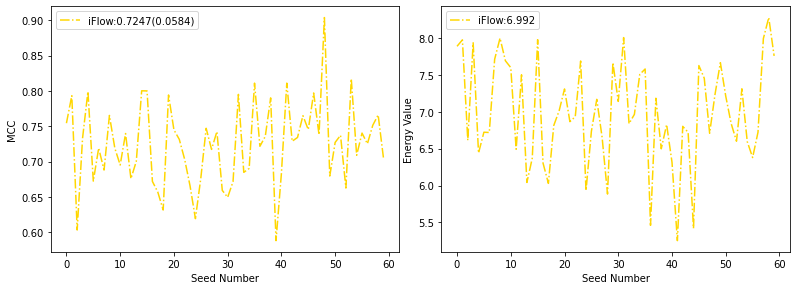

In [4]:
plot_test_performances()

## Visualization of 2D cases (seed 1 to 10)

iFlow mean 0.7727, std 0.0770
iVAE mean  0.8176, std 0.0561
len iFlow array: 10
len iVAE array: 10
Dataset seed = 1


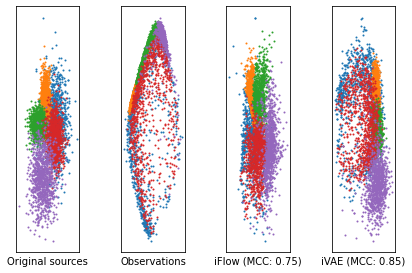

Dataset seed = 2


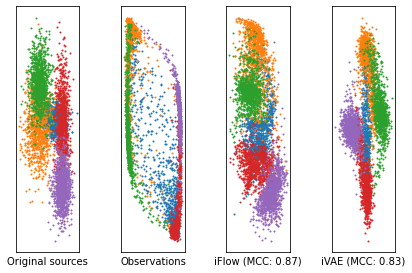

Dataset seed = 3


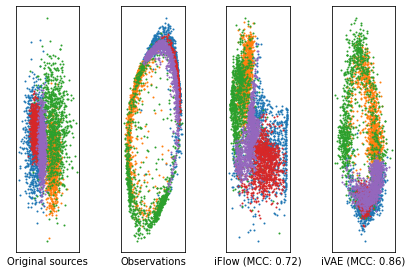

Dataset seed = 4


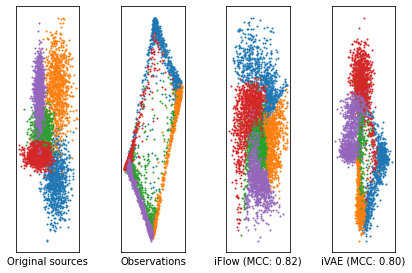

Dataset seed = 5


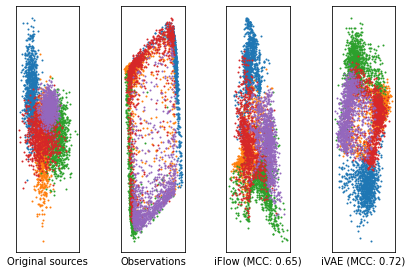

Dataset seed = 6


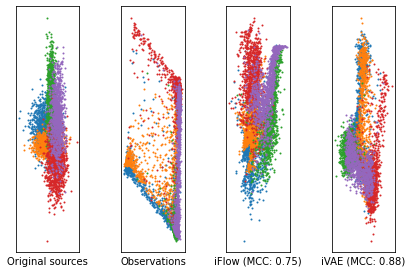

Dataset seed = 7


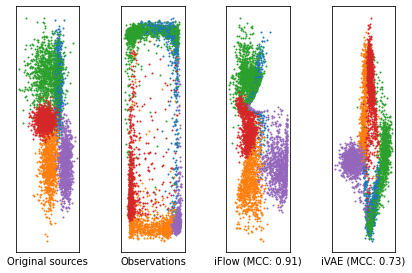

Dataset seed = 8


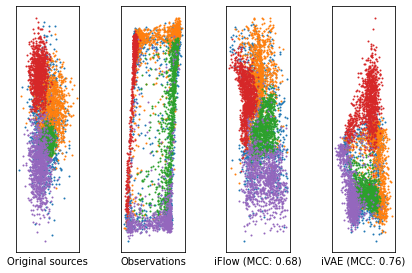

Dataset seed = 9


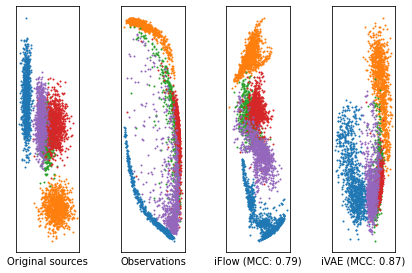

Dataset seed = 10


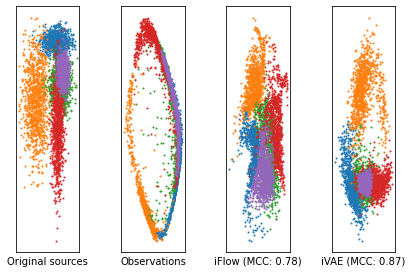

In [6]:
# Arguments for the used 2D dataset is the following string: '1000_5_2_2_3_$seed_gauss_xtanh_u_f'
# For plotting, seed argument will automatically be replaced by the correct seed (1-10)

iFlow_file = 'iFlow_RQNSF_AG_1000_5_3.txt'
iVAE_file = 'iVAE_1000_5_3.txt'

seeds = range(1, 11)
data_args = "1000_5_2_2_3_$seed_gauss_xtanh_u_f"

load_plot_2d(seeds, data_args, iFlow_results_file=iFlow_file, iVAE_results_file=iVAE_file)

# Consistency across latent dimensions

In [31]:
correlation_coefficients()

TypeError: correlation_coefficients() missing 2 required positional arguments: 'x' and 'y'

## Running the experiments

To train and evaluate an iFlow model on the standard dataset using a given seed, the following script can be run. 

% Geef uitleg over arguments zoals in  https://github.com/uva-fact-ai-course/uva-fact-ai-course/blob/master/DL-prototypes/results.ipynb

In [ ]:
!python main.py \
        -x 1000_40_5_5_3_1_gauss_xtanh_u_f \
        -i iFlow \
        -ft RQNSF_AG \
        -npa Softplus \
        -fl 10 \
        -lr_df 0.25 \
        -lr_pn 10 \
        -b 64 \
        -e 20 \
        -l 1e-3 \
        -s 1 \
        -u 0 \
        -c

In [30]:
def correlation_coefficients(x, y, method='pearson'):
    """
    A numpy implementation of the mean correlation coefficient metric.

    :param x: numpy.ndarray
    :param y: numpy.ndarray
    :param method: str, optional
            The method used to compute the correlation coefficients.
    :return: float
    """
    d = x.shape[1]
    if method == 'pearson':
        cc = np.corrcoef(x, y, rowvar=False)[:d, d:]
    else:
        raise ValueError('not a valid method: {}'.format(method))
    cc_matrix = np.abs(cc)

    corr_coefs = cc_matrix[linear_sum_assignment(-1 * cc_matrix)] #.mean()
    return corr_coefs
